In [ ]:
'''
This notebook shows how the model was made. It can't be run as data is not provided in the repository.
'''

## Necessary Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Cell 1: Import libraries and setup
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')
from config.config import Config
from utils.data_downloader import DataDownloader
from utils.preprocessing import DataPreprocessor
from utils.model_utils import SketchCNNModel

# Initialize configuration
config = Config()
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: []


## DATA COLLECTION

In [2]:


# Initialize data downloader
downloader = DataDownloader()

# Download Quick Draw data (this may take some time)
print("Downloading Quick Draw dataset...")
downloader.download_quickdraw_data(max_samples=3000)  # Reduced for faster processing

# Create synthetic UI data
print("Creating synthetic UI data...")
downloader.create_synthetic_ui_data()

print("Data download completed!")


Downloaded envelope.npy


Error downloading gear: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/gear.npy


Error downloading arrow: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/arrow.npy


Error downloading plus: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/plus.npy


Error downloading heart: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/heart.npy


Error downloading check: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/check.npy


Error downloading x: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/x.npy


Downloaded mountain.npy


Downloaded tree.npy


Downloaded sun.npy


Downloaded moon.npy


Downloaded cloud.npy


Error downloading rectangle: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/rectangle.npy


Error downloading dot: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dot.npy


Error downloading frame: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/frame.npy


Error downloading light switch: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/light%20switch.npy


Downloaded power outlet.npy


Error downloading scribble: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/scribble.npy


Downloaded zigzag.npy


Error downloading abstract: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/abstract.npy
Creating synthetic UI data...
Generating button images...


Generating input images...
Generating label images...
Generating checkbox images...
Generating header images...
Generating image images...
Generating icon images...
Generating slider images...
Generating radio images...
Generating switch images...
Generating text images...
Generating card images...
Generating list_item images...
Generating toolbar images...
Generating modal images...
✅ Synthetic UI data created successfully
Data download completed!


In [7]:
preprocessor = DataPreprocessor()

def check_data_loading(X_data, name="Dataset"):
    print(f"\n{name} Statistics:")
    print(f"Shape: {X_data.shape}")
    print(f"Data type: {X_data.dtype}")
    print(f"Range: [{X_data.min()}, {X_data.max()}]")
    print(f"Mean: {X_data.mean():.4f}")
    
# Load Quick Draw data
print("Loading Quick Draw data...")
X_quick, y_quick = preprocessor.load_quickdraw_data(max_samples_per_class=2000)
print(f"Quick Draw data shape: {X_quick.shape}, Labels: {len(y_quick)}")
check_data_loading(X_quick, "QuickDraw")

# Load synthetic UI data
print("Loading synthetic UI data...")
X_ui, y_ui = preprocessor.load_synthetic_ui_data()
print(f"Synthetic UI data shape: {X_ui.shape}, Labels: {len(y_ui)}")
check_data_loading(X_ui, "Synthetic UI")

# Combine datasets
print("Combining datasets...")
X_combined = np.concatenate([X_quick, X_ui])
y_combined = np.concatenate([y_quick, y_ui])
print(f"Combined data shape: {X_combined.shape}")

# Show data distribution
unique_labels, counts = np.unique(y_combined, return_counts=True)
print(f"Class distribution:")
for label, count in zip(unique_labels, counts):
    print(f"  {label}: {count} samples")

Loading Quick Draw data...


Loading Quick Draw data: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Quick Draw data shape: (14000, 64, 64, 3), Labels: 14000

QuickDraw Statistics:
Shape: (14000, 64, 64, 3)
Data type: float32
Range: [0.0, 1.0]
Mean: 0.1411
Loading synthetic UI data...


Loading switch: 100%|██████████| 100/100 [00:00<00:00, 114.15it/s]


Synthetic UI data shape: (1000, 64, 64, 3), Labels: 1000

Synthetic UI Statistics:
Shape: (1000, 64, 64, 3)
Data type: float32
Range: [0.0, 1.0]
Mean: 0.9040
Combining datasets...
Combined data shape: (15000, 64, 64, 3)
Class distribution:
  qd_circle: 2000 samples
  qd_diamond: 2000 samples
  qd_house: 2000 samples
  qd_line: 2000 samples
  qd_square: 2000 samples
  qd_star: 2000 samples
  qd_triangle: 2000 samples
  ui_button: 100 samples
  ui_checkbox: 100 samples
  ui_header: 100 samples
  ui_icon: 100 samples
  ui_image: 100 samples
  ui_input: 100 samples
  ui_label: 100 samples
  ui_radio: 100 samples
  ui_slider: 100 samples
  ui_switch: 100 samples


## DATA AUGMENTATION 

In [8]:


# Apply data augmentation
print("Applying data augmentation...")
X_augmented, y_augmented = preprocessor.augment_data(X_combined, y_combined, augmentation_factor=1)
print(f"Augmented data shape: {X_augmented.shape}")

# Normalize pixel values
print("Normalizing data...")
X_normalized = X_augmented
print(f"Data normalized to range [{X_normalized.min():.2f}, {X_normalized.max():.2f}]")

# Encode labels
print("Encoding labels...")
y_encoded = preprocessor.encode_labels(y_augmented)
print(f"Labels encoded: {len(np.unique(y_encoded))} unique classes")

Applying data augmentation...


Augmenting data: 100%|██████████| 15000/15000 [00:04<00:00, 3029.53it/s]


Augmented data shape: (37406, 64, 64, 3)
Normalizing data...
Data normalized to range [0.00, 1.00]
Encoding labels...
Labels encoded: 17 unique classes


### Sample data visualization

In [9]:
y_encoded.shape

(37406,)

<class 'numpy.int64'> 0
<class 'numpy.int64'> 1
<class 'numpy.int64'> 2
<class 'numpy.int64'> 3
<class 'numpy.int64'> 4
<class 'numpy.int64'> 5
<class 'numpy.int64'> 6
<class 'numpy.int64'> 7
<class 'numpy.int64'> 8
<class 'numpy.int64'> 9
<class 'numpy.int64'> 10
<class 'numpy.int64'> 11
<class 'numpy.int64'> 12
<class 'numpy.int64'> 13
<class 'numpy.int64'> 14
<class 'numpy.int64'> 15
<class 'numpy.int64'> 16


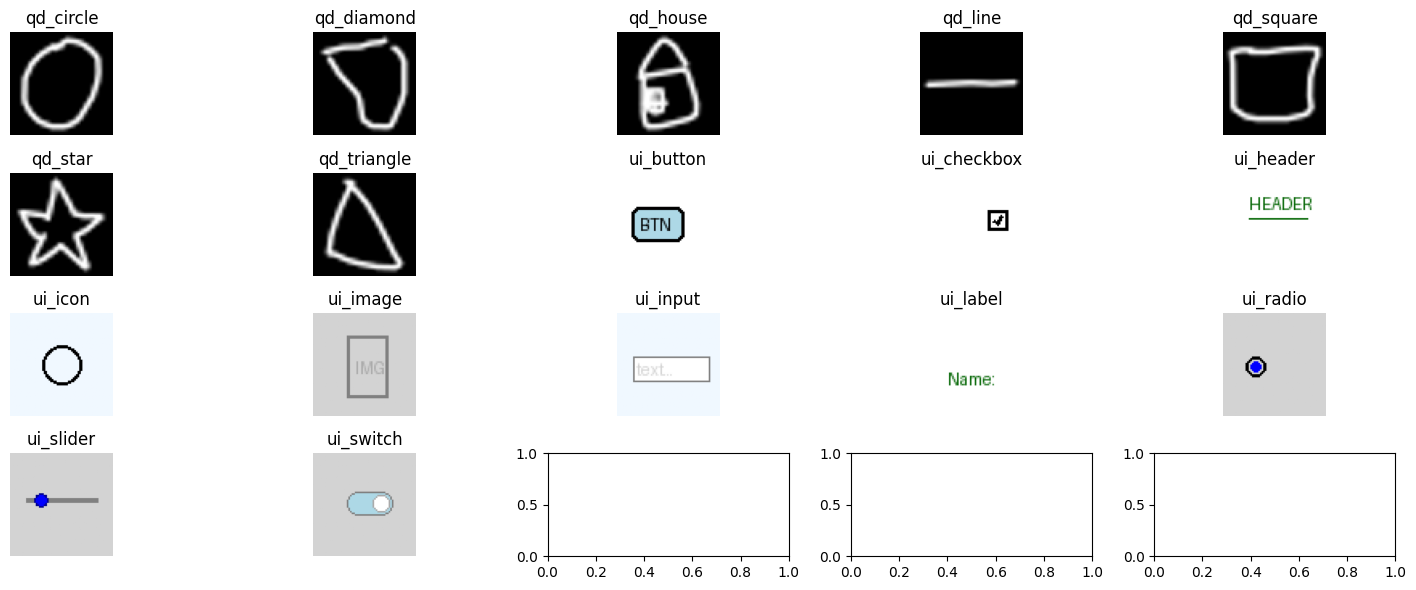

In [10]:
# Cell 6: Visualize sample images


# Plot sample images from each class
fig, axes = plt.subplots(4, 5, figsize=(15, 6))
axes = axes.ravel()

# Get class names
class_names = preprocessor.label_encoder.classes_
unique_classes = np.unique(y_encoded)

for i, class_idx in enumerate(unique_classes):  # Show first 10 classes
    print(type(class_idx), class_idx)
    # Find first image of this class
    class_indices = np.where(y_encoded == class_idx)[0]
    if len(class_indices) > 0:
        sample_idx = class_indices[0]
        sample_image = X_augmented[sample_idx]
        
        axes[i].imshow(sample_image)
        axes[i].set_title(f'{class_names[class_idx]}')
        axes[i].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(config.MODEL_DIR, 'sample_images.png'), dpi=300)
plt.show()

In [11]:
X_normalized.shape, y_encoded.shape
X_normalized[:5], y_encoded[:5]

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

## DATA SPLITTING

Training set: (22443, 64, 64, 3)
Validation set: (7481, 64, 64, 3)
Test set: (7482, 64, 64, 3)
Saving processed data...
Processed data saved to c:\Users\NACHIKET\Desktop\SR\data\processed
Data distribution plot saved to: c:\Users\NACHIKET\Desktop\SR\data\processed\data_distribution.png


<Figure size 1500x400 with 0 Axes>

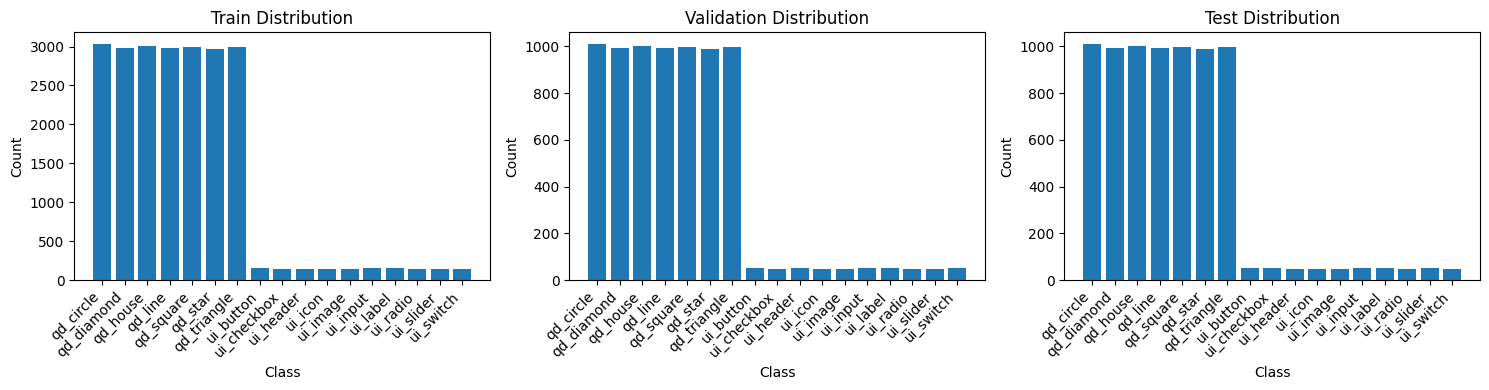


Class Distribution Summary:

Train Set:
  qd_circle: 3031 samples
  qd_diamond: 2983 samples
  qd_house: 3007 samples
  qd_line: 2981 samples
  qd_square: 2989 samples
  qd_star: 2973 samples
  qd_triangle: 2995 samples
  ui_button: 153 samples
  ui_checkbox: 148 samples
  ui_header: 148 samples
  ui_icon: 145 samples
  ui_image: 146 samples
  ui_input: 151 samples
  ui_label: 150 samples
  ui_radio: 147 samples
  ui_slider: 148 samples
  ui_switch: 148 samples

Val Set:
  qd_circle: 1010 samples
  qd_diamond: 994 samples
  qd_house: 1002 samples
  qd_line: 994 samples
  qd_square: 996 samples
  qd_star: 991 samples
  qd_triangle: 998 samples
  ui_button: 51 samples
  ui_checkbox: 49 samples
  ui_header: 50 samples
  ui_icon: 49 samples
  ui_image: 49 samples
  ui_input: 50 samples
  ui_label: 50 samples
  ui_radio: 49 samples
  ui_slider: 49 samples
  ui_switch: 50 samples

Test Set:
  qd_circle: 1010 samples
  qd_diamond: 994 samples
  qd_house: 1002 samples
  qd_line: 994 samples
 

In [12]:


# Split data into train, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data(
    X_normalized, y_encoded, test_size=0.2, val_size=0.2
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Save processed data
preprocessor.save_processed_data(X_train, X_val, X_test, y_train, y_val, y_test)

# Visualize data distribution
preprocessor.visualize_data_distribution(y_train, y_val, y_test)


=== SAMPLE DATA VISUALIZATION ===


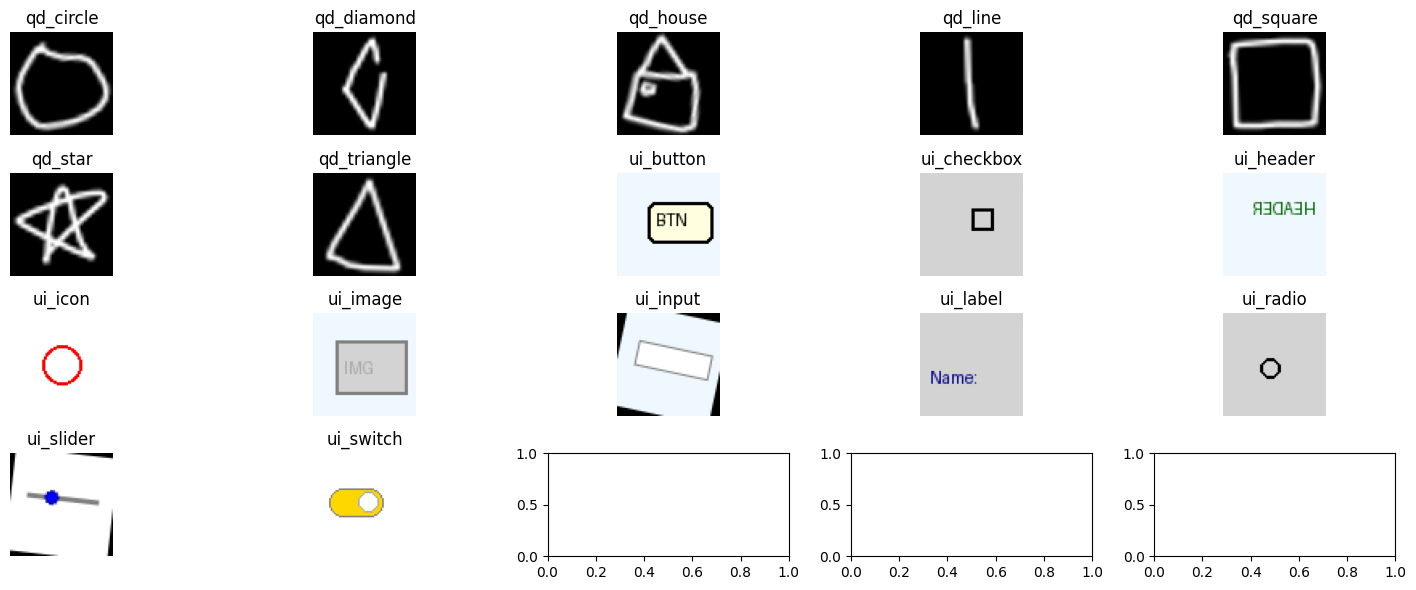

In [13]:
# Cell 6: Visualize sample images
print("\n=== SAMPLE DATA VISUALIZATION ===")

# Plot sample images from each class
fig, axes = plt.subplots(4, 5, figsize=(15, 6))
axes = axes.ravel()

# Get class names
class_names = preprocessor.label_encoder.classes_
unique_classes = np.unique(y_train)

for i, class_idx in enumerate(unique_classes[:20]):  # Show first 10 classes
    # Find first image of this class
    class_indices = np.where(y_train == class_idx)[0]
    if len(class_indices) > 0:
        sample_idx = class_indices[0]
        sample_image = X_train[sample_idx]
        
        axes[i].imshow(sample_image, cmap='gray')
        axes[i].set_title(f'{class_names[class_idx]}')
        axes[i].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(config.MODEL_DIR, 'sample_images.png'), dpi=300)

plt.show()


#### Pre training verification

In [14]:
# Check actual classes in processed data
actual_classes = len(np.unique(y_train))
print(f"Actual classes in training data: {actual_classes}")
print(f"Config NUM_CLASSES: {config.NUM_CLASSES}")

# Update config if needed
if actual_classes != config.NUM_CLASSES:
    print(f"⚠️ Updating NUM_CLASSES from {config.NUM_CLASSES} to {actual_classes}")
    config.NUM_CLASSES = actual_classes

# Verify data quality
print(f"Data range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"Zero pixels ratio: {(X_train == 0).mean():.3f}")

if (X_train == 0).mean() > 0.8:
    print("⚠️ WARNING: >80% pixels are zero - check for empty images!")

Actual classes in training data: 17
Config NUM_CLASSES: 17
Data range: [0.000, 1.000]
Zero pixels ratio: 0.649


## MODEL BUILDING AND TRAINING

Building model...

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,279,441 (4.88 MB)

 Trainable params: 1,278,481 (4.88 MB)

 Non-trainable params: 960 (3.75 KB)


Total parameters: 1,279,441

Data loaded: Train (22443, 64, 64, 3), Val (7481, 64, 64, 3), Test (7482, 64, 64, 3)
Training model...
Epoch 1/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8173 - loss: 0.7102 - top_3_accuracy: 0.9143
Epoch 1: val_accuracy improved from -inf to 0.91285, saving model to c:\Users\NACHIKET\Desktop\SR\model\baseline_model.h5


702/702 ━━━━━━━━━━━━━━━━━━━━ 108s 148ms/step - accuracy: 0.8173 - loss: 0.7098 - top_3_accuracy: 0.9143 - val_accuracy: 0.9128 - val_loss: 0.2992 - val_top_3_accuracy: 0.9702 - learning_rate: 0.0010
Epoch 2/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9114 - loss: 0.3061 - top_3_accuracy: 0.9709
Epoch 2: val_accuracy improved from 0.91285 to 0.94225, saving model to c:\Users\NACHIKET\Desktop\SR\model\baseline_model.h5


702/702 ━━━━━━━━━━━━━━━━━━━━ 98s 139ms/step - accuracy: 0.9114 - loss: 0.3061 - top_3_accuracy: 0.9709 - val_accuracy: 0.9423 - val_loss: 0.1984 - val_top_3_accuracy: 0.9833 - learning_rate: 0.0010
Epoch 3/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9360 - loss: 0.2266 - top_3_accuracy: 0.9814
Epoch 3: val_accuracy improved from 0.94225 to 0.95281, saving model to c:\Users\NACHIKET\Desktop\SR\model\baseline_model.h5


702/702 ━━━━━━━━━━━━━━━━━━━━ 99s 141ms/step - accuracy: 0.9360 - loss: 0.2266 - top_3_accuracy: 0.9814 - val_accuracy: 0.9528 - val_loss: 0.1689 - val_top_3_accuracy: 0.9866 - learning_rate: 0.0010
Epoch 4/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9468 - loss: 0.1810 - top_3_accuracy: 0.9864
Epoch 4: val_accuracy improved from 0.95281 to 0.95589, saving model to c:\Users\NACHIKET\Desktop\SR\model\baseline_model.h5


702/702 ━━━━━━━━━━━━━━━━━━━━ 99s 141ms/step - accuracy: 0.9468 - loss: 0.1810 - top_3_accuracy: 0.9864 - val_accuracy: 0.9559 - val_loss: 0.1528 - val_top_3_accuracy: 0.9888 - learning_rate: 0.0010
Epoch 5/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9530 - loss: 0.1589 - top_3_accuracy: 0.9900
Epoch 5: val_accuracy improved from 0.95589 to 0.96017, saving model to c:\Users\NACHIKET\Desktop\SR\model\baseline_model.h5


702/702 ━━━━━━━━━━━━━━━━━━━━ 97s 138ms/step - accuracy: 0.9530 - loss: 0.1589 - top_3_accuracy: 0.9900 - val_accuracy: 0.9602 - val_loss: 0.1440 - val_top_3_accuracy: 0.9897 - learning_rate: 0.0010
Epoch 6/10
701/702 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9564 - loss: 0.1424 - top_3_accuracy: 0.9917
Epoch 6: val_accuracy did not improve from 0.96017
702/702 ━━━━━━━━━━━━━━━━━━━━ 98s 139ms/step - accuracy: 0.9564 - loss: 0.1424 - top_3_accuracy: 0.9917 - val_accuracy: 0.9554 - val_loss: 0.1591 - val_top_3_accuracy: 0.9897 - learning_rate: 0.0010
Epoch 7/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9629 - loss: 0.1215 - top_3_accuracy: 0.9926
Epoch 7: val_accuracy improved from 0.96017 to 0.96404, saving model to c:\Users\NACHIKET\Desktop\SR\model\baseline_model.h5


702/702 ━━━━━━━━━━━━━━━━━━━━ 99s 141ms/step - accuracy: 0.9629 - loss: 0.1215 - top_3_accuracy: 0.9926 - val_accuracy: 0.9640 - val_loss: 0.1275 - val_top_3_accuracy: 0.9912 - learning_rate: 0.0010
Epoch 8/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9647 - loss: 0.1142 - top_3_accuracy: 0.9948
Epoch 8: val_accuracy improved from 0.96404 to 0.96899, saving model to c:\Users\NACHIKET\Desktop\SR\model\baseline_model.h5


702/702 ━━━━━━━━━━━━━━━━━━━━ 98s 140ms/step - accuracy: 0.9647 - loss: 0.1142 - top_3_accuracy: 0.9948 - val_accuracy: 0.9690 - val_loss: 0.1181 - val_top_3_accuracy: 0.9933 - learning_rate: 0.0010
Epoch 9/10
701/702 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9696 - loss: 0.1108 - top_3_accuracy: 0.9942
Epoch 9: val_accuracy did not improve from 0.96899
702/702 ━━━━━━━━━━━━━━━━━━━━ 97s 138ms/step - accuracy: 0.9696 - loss: 0.1108 - top_3_accuracy: 0.9942 - val_accuracy: 0.9682 - val_loss: 0.1208 - val_top_3_accuracy: 0.9937 - learning_rate: 0.0010
Epoch 10/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9710 - loss: 0.0959 - top_3_accuracy: 0.9955
Epoch 10: val_accuracy improved from 0.96899 to 0.96939, saving model to c:\Users\NACHIKET\Desktop\SR\model\baseline_model.h5


702/702 ━━━━━━━━━━━━━━━━━━━━ 96s 136ms/step - accuracy: 0.9710 - loss: 0.0959 - top_3_accuracy: 0.9955 - val_accuracy: 0.9694 - val_loss: 0.1179 - val_top_3_accuracy: 0.9930 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 10.
Plotting training history...
Training history saved to c:\Users\NACHIKET\Desktop\SR\model\training_history.png


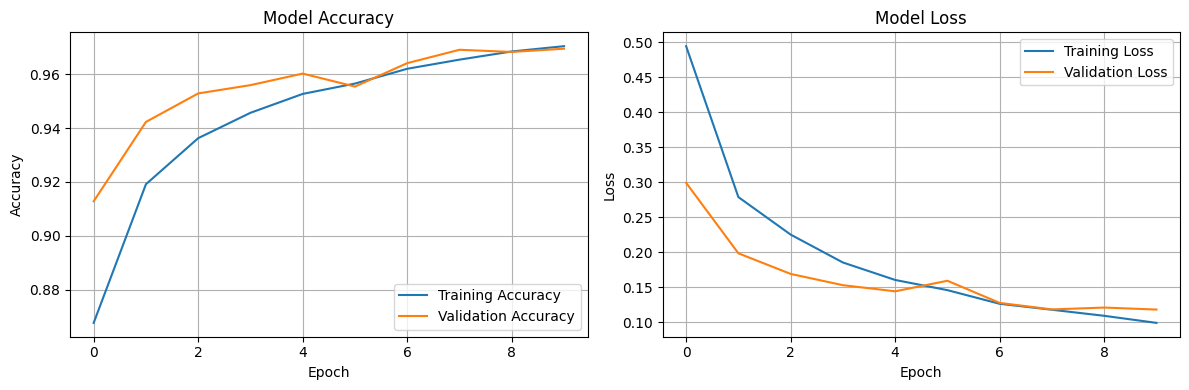

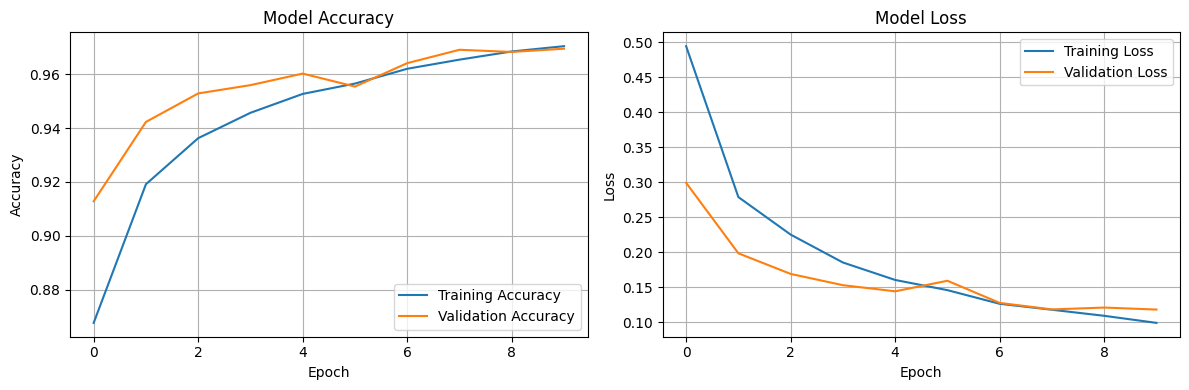

In [15]:
from utils.model_utils import SketchCNNModel


# Build and compile model
print("Building model...")
model_builder = SketchCNNModel()
model = model_builder.build_baseline_cnn()
model = model_builder.compile_model()

# Display model summary
print("\nModel Architecture:")
model_builder.get_model_summary()

print(f"\nData loaded: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")

# Train model
print("Training model...")
history = model_builder.train_model(X_train, y_train, X_val, y_val, epochs=10)

# Plot training history
print("Plotting training history...")
model_builder.plot_training_history(
    save_path=os.path.join(config.MODEL_DIR, 'training_history.png')
)

## MODEL EVALUATION


In [16]:


# Evaluate model
results = model_builder.evaluate_model(X_test, y_test)

print(f"\n📊 BASELINE PERFORMANCE METRICS:")
print(f"{'='*50}")
print(f"Test Accuracy:     {results['test_accuracy']:.4f}")
print(f"Top-3 Accuracy:    {results['top_3_accuracy']:.4f}")
print(f"Test Loss:         {results['test_loss']:.4f}")

# Per-class analysis
from sklearn.metrics import classification_report
class_names = preprocessor.label_encoder.classes_
report = classification_report(y_test, results['predictions'], 
                             target_names=class_names, output_dict=True)

print(f"\n📈 PER-CLASS PERFORMANCE:")
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 50)
for class_name in class_names:
    if class_name in report:
        p = report[class_name]['precision']
        r = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        print(f"{class_name:<15} {p:<10.3f} {r:<10.3f} {f1:<10.3f}")

# Data source analysis
qd_classes = [c for c in class_names if c.startswith('qd_')]
ui_classes = [c for c in class_names if c.startswith('ui_')]

print(f"\n🎯 SOURCE-WISE PERFORMANCE:")
print(f"QuickDraw classes ({len(qd_classes)}): {qd_classes}")
print(f"UI classes ({len(ui_classes)}): {ui_classes}")

234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step

📊 BASELINE PERFORMANCE METRICS:
Test Accuracy:     0.9710
Top-3 Accuracy:    0.9930
Test Loss:         0.1073

📈 PER-CLASS PERFORMANCE:
Class           Precision  Recall     F1-Score  
--------------------------------------------------
qd_circle       0.976      0.976      0.976     
qd_diamond      0.966      0.971      0.968     
qd_house        0.982      0.972      0.977     
qd_line         0.964      0.976      0.970     
qd_square       0.966      0.964      0.965     
qd_star         0.977      0.961      0.969     
qd_triangle     0.966      0.978      0.972     
ui_button       1.000      0.941      0.970     
ui_checkbox     1.000      1.000      1.000     
ui_header       0.860      0.878      0.869     
ui_icon         1.000      0.980      0.990     
ui_image        0.980      1.000      0.990     
ui_input        1.000      0.980      0.990     
ui_label        0.885      0.920      0.902     
ui_radio        0.980      1.000   

In [18]:
# Replace your final evaluation cell (Cell id="7fa5b0b7") with this:

print("=== FINAL MODEL EVALUATION ===")

try:
    # Evaluate model
    print("Evaluating model on test set...")
    results = model_builder.evaluate_model(X_test, y_test)

    print(f"\nFinal Results:")
    print(f"Test Accuracy: {results['test_accuracy']:.4f}")
    print(f"Top-3 Accuracy: {results['top_3_accuracy']:.4f}")
    print(f"Test Loss: {results['test_loss']:.4f}")

    # Ensure class_names exists
    if 'class_names' not in locals():
        try:
            class_names = preprocessor.label_encoder.classes_
        except:
            class_names = []
            for qd_cat in config.QUICKDRAW_CATEGORIES:
                class_names.append(f"qd_{qd_cat}")
            for ui_cat in config.UI_CLASSES:
                class_names.append(f"ui_{ui_cat}")

    # Generate classification report
    try:
        model_builder.generate_classification_report(
            y_test, results['predictions'], class_names
        )
    except Exception as e:
        print(f"⚠️ Classification report error: {e}")

    # Plot confusion matrix
    try:
        model_builder.plot_confusion_matrix(
            y_test, results['predictions'], class_names,
            save_path=os.path.join(config.MODEL_DIR, 'confusion_matrix.png')
        )
        print("✅ Confusion matrix saved")
    except Exception as e:
        print(f"⚠️ Confusion matrix error: {e}")

    # Save final model
    try:
        model_builder.save_model(os.path.join(config.MODEL_DIR, 'baseline_model.h5'))
        print("✅ Model saved successfully")
    except Exception as e:
        print(f"⚠️ Model saving error: {e}")

    print("\n✅ Training completed successfully!")
    
except Exception as e:
    print(f"❌ Evaluation failed: {e}")
    print("\n🔧 Troubleshooting:")
    print("1. Check if model training completed successfully")
    print("2. Verify test data shapes match model expectations")
    print("3. Ensure all required methods exist in model_utils.py")

=== FINAL MODEL EVALUATION ===
Evaluating model on test set...
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step

Final Results:


Test Accuracy: 0.9710
Top-3 Accuracy: 0.9930
Test Loss: 0.1073
Classification Report:
              precision    recall  f1-score   support

   qd_circle       0.98      0.98      0.98      1010
  qd_diamond       0.97      0.97      0.97       994
    qd_house       0.98      0.97      0.98      1002
     qd_line       0.96      0.98      0.97       994
   qd_square       0.97      0.96      0.96       996
     qd_star       0.98      0.96      0.97       991
 qd_triangle       0.97      0.98      0.97       999
   ui_button       1.00      0.94      0.97        51
 ui_checkbox       1.00      1.00      1.00        50
   ui_header       0.86      0.88      0.87        49
     ui_icon       1.00      0.98      0.99        49
    ui_image       0.98      1.00      0.99        49
    ui_input       1.00      0.98      0.99        50
    ui_label       0.88      0.92      0.90        50
    ui_radio       0.98      1.00      0.99        49
   ui_slider       1.00      1.00      1.00     

<Figure size 1200x1000 with 0 Axes>